# Price stock tendency prediction

## Setup

In [2]:
%load_ext autoreload
%autoreload 2

from notebook_config import setup_notebook
import matplotlib.pyplot as plt
import numpy as np

setup_notebook()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from tqdm.notebook import trange, tqdm

from helpers.data_helper import *

In [13]:
DATA_PATH = '../data/'
quotation = 'AMZN'
FILE_SUFFIX = '.txt'
price_column = 'Close'

In [19]:
from datasets.stocks_data_wrapper import StocksDataWrapper
data_wrapper = StocksDataWrapper.read_from(f"{DATA_PATH}{quotation}{FILE_SUFFIX}")
data_wrapper.compute_features(predict_n=1)
data_wrapper.head()

,Date,Open,High,Low,Close,Volume,Adjusted,LowLen,RSI(14),GAP,...,SMA(10),SMA(20),EMA(14),EMA_Diff,SMA(20) - SMA(10),Difference,PercentageDiff,Tendency,NextPrice,Next
0,2007-02-21,41.189999,41.320000,40.919998,41.259998,4508400,41.259998,0.270001,68.845724,0.319999,...,39.826,38.6560,39.568322,0.260258,-1.1700,-0.250000,-0.006023,lower,41.000000,lower
1,2007-02-22,41.400002,42.000000,40.889999,41.000000,4926100,41.000000,0.110001,66.065593,0.140004,...,40.028,38.8430,39.759213,0.190890,-1.1850,-0.259998,-0.006301,lower,40.779999,lower
2,2007-02-23,41.000000,41.200001,40.740002,40.779999,5497400,40.779999,0.039997,63.720777,0.000000,...,40.196,39.0280,39.895317,0.136105,-1.1680,-0.220001,-0.005366,lower,40.880001,higher
3,2007-02-26,40.860001,41.200001,40.400002,40.880001,4035200,40.880001,0.459999,64.340331,0.080002,...,40.412,39.2295,40.026609,0.131291,-1.1825,0.100002,0.002452,higher,38.830002,lower
4,2007-02-27,40.189999,40.540001,38.779999,38.830002,8850700,38.830002,0.050003,46.724718,0.690002,...,40.410,39.2995,39.867061,-0.159548,-1.1105,-2.049999,-0.050147,lower,39.139999,higher


### Plots

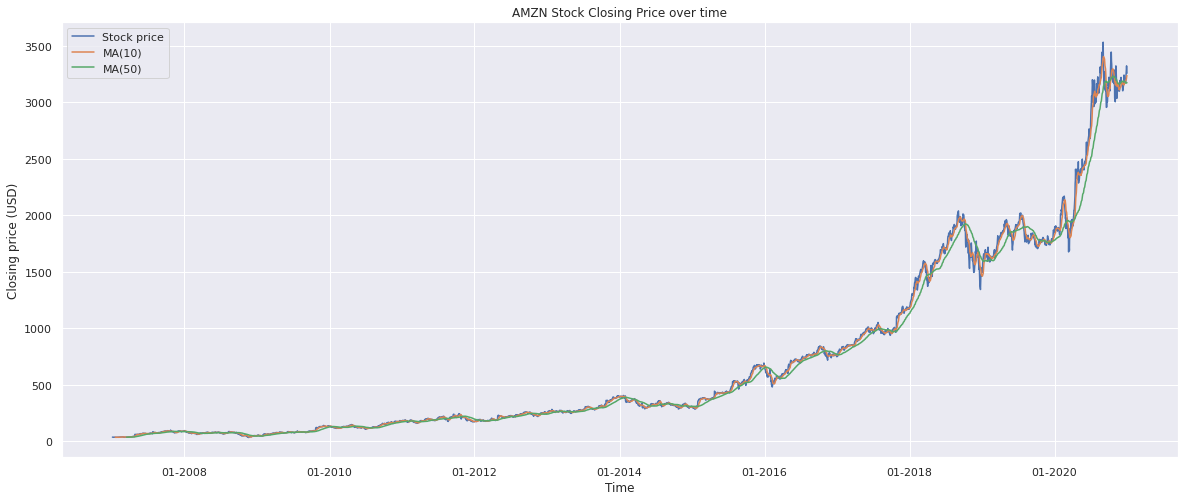

In [18]:
from helpers.plots_helper import plot_prices

ax = plot_prices(data_wrapper['Date'], data_wrapper[price_column], quotation_name=quotation, ma_values=[10,50])

### ML Data preparation

In [16]:
data_columns = ['Close', 'PercentageDiff', f"RSI({N})", 'Next', 'Volume']

dataset = df.copy()

dataset = df.loc[:, data_columns]
#df = df.drop(columns=['Tendency', 'Date', 'Difference'])

dataset.head()

,Close,PercentageDiff,RSI(14),Next,Volume
20,37.669998,1.673412,47.586173,higher,7277500
21,38.700001,2.734279,69.196427,lower,26123100
22,37.389999,-3.385018,53.217380,lower,25850700
23,37.160000,-0.615135,51.776640,higher,6110900
24,38.270000,2.987083,64.153837,higher,8612700


### Dataset class balance

<AxesSubplot:>

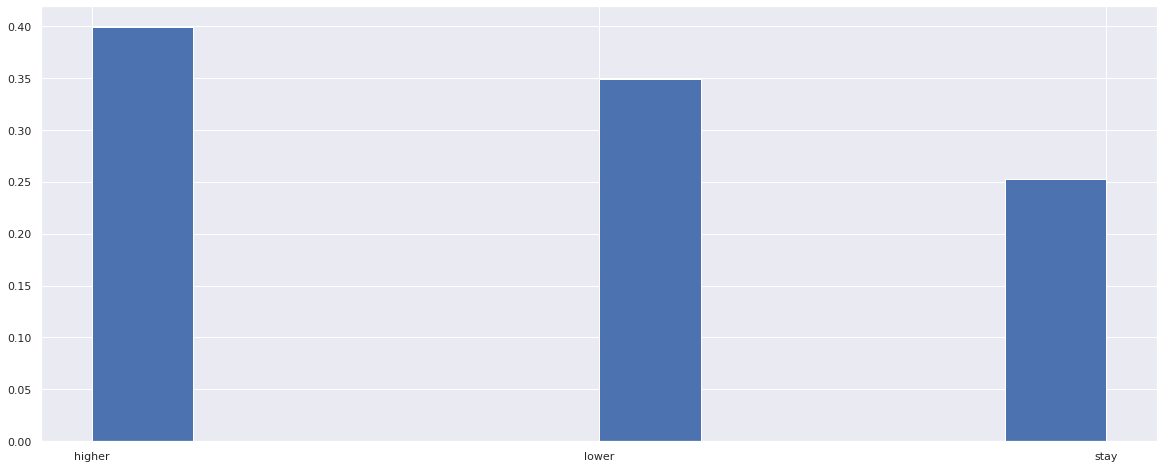

In [17]:
# plot normalized histogram
dataset['Next'].hist(weights = np.ones_like(dataset.Next) / len(dataset.Next))

### Train / Test data 

In [18]:
X = dataset.loc[:, dataset.columns != 'Next']
Y = dataset['Next']

In [19]:
from sklearn.model_selection import train_test_split
TRAIN_RATIO = 0.7

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=TRAIN_RATIO, random_state=42)

print(f"Train size : {len(X_train)}, test size : {len(X_test)} ({(1-TRAIN_RATIO)*100:.0f}%)")

# use bins

Train size : 2453, test size : 1052 (30%)


## Classifier and evaluation

In [20]:
from sklearn.utils.class_weight import compute_class_weight

USE_CLASS_WEIGHTS = False

if USE_CLASS_WEIGHTS:
    class_weights = compute_class_weight('balanced', np.unique(Y), Y)
    # format as dict
    class_weights = {c:w for c,w in zip(np.unique(Y), class_weights)}

    print(class_weights)
else:
    class_weights = None

### Grid Search

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

PERFORM_GRID_SEARCH = False

# default parameters
best_params = {'DTree': {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 15}, 
               'RandomForest': {'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 10, 'n_estimators': 100}, 
               'SVM': {'gamma': 'auto'}, 
               'LR': {'penalty': 'l2', 'C': 1.0}
              }

param_grid = {
    'DTree':{
        'criterion':('entropy', 'gini'),
        'max_depth':[1,2,3,5,8,10],
        'min_samples_leaf':[1,2,3,5,10,15],
    },
    'RandomForest':{
        'criterion':('entropy', 'gini'),
        'n_estimators':[50,100,200,500],
        'max_depth':[2,3,5,8,10],
        'min_samples_leaf':[1,2,3,5,10,15],
        'max_features':['auto', 'sqrt', 'log2'], 
    },
    'SVM':{
        'C':[1.0],
        'kernel':('linear', 'poly', 'rbf'),
        'gamma':('scale', 'auto'),
    },
    'LR':
    {
        'penalty':('none', 'l2'),
        'C':[0.5, 1.0]
    },   
    
}

if PERFORM_GRID_SEARCH:
    print("Performing grid search...")
    dtree = DecisionTreeClassifier(random_state=42, class_weight=class_weights)
    clf = GridSearchCV(dtree, param_grid['DTree'], n_jobs=4)

    
    clf.fit(X_train, Y_train)
    best_params['DTree'] = clf.best_params_

    random_forest = RandomForestClassifier(random_state=42, class_weight=class_weights)
    clf = GridSearchCV(random_forest, param_grid['RandomForest'], n_jobs=8)
    clf.fit(X_train, Y_train)
    best_params['RandomForest'] = clf.best_params_

    
    """svm = SVC(random_state=42, class_weight=class_weights, cache_size=4096)
    clf = GridSearchCV(svm, param_grid['SVM'], n_jobs=4, verbose=30)
    clf.fit(X_train, Y_train)
    best_params['SVM'] = clf.best_params_"""
    
    lr = LogisticRegression(random_state=42, class_weight=class_weights)
    clf = GridSearchCV(lr, param_grid['LR'], n_jobs=4)
    clf.fit(X_train, Y_train)


    print(best_params)

### Classifiers

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

clf_dict = {}

clf_dict['DTree'] = DecisionTreeClassifier(**best_params['DTree'], random_state=42, class_weight=class_weights)
clf_dict['RandomForest'] = RandomForestClassifier(**best_params['RandomForest'], random_state=42, class_weight=class_weights)
clf_dict['SVM'] = SVC(**best_params['SVM'], class_weight=class_weights)
clf_dict['LR'] = LogisticRegression(**best_params['LR'], class_weight=class_weights)

### Training

In [23]:
print("Training...")

for clf_label, clf in clf_dict.items():
    clf.fit(X_train, Y_train)
    
print("Training done.")

Training...
Training done.


[DTree] Accuracy : 0.39, F1 : 0.39
[RandomForest] Accuracy : 0.40, F1 : 0.48
[SVM] Accuracy : 0.42, F1 : 0.59
[LR] Accuracy : 0.40, F1 : 0.46


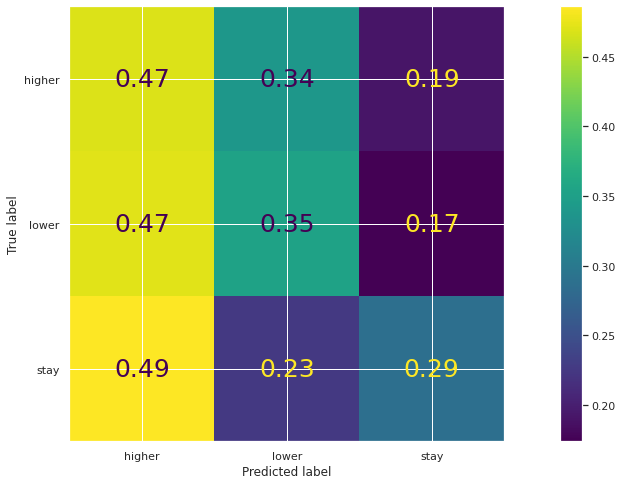

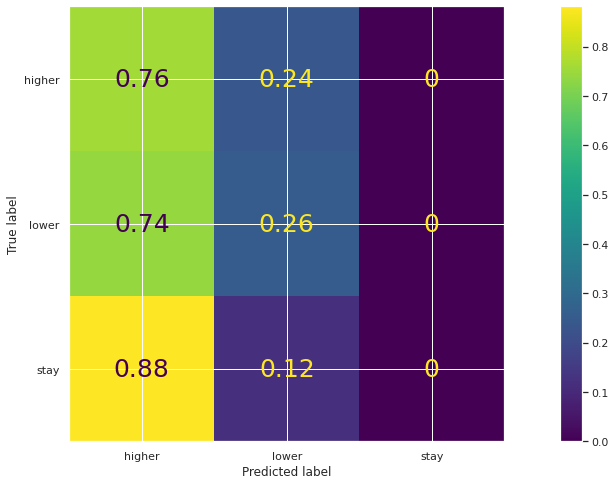

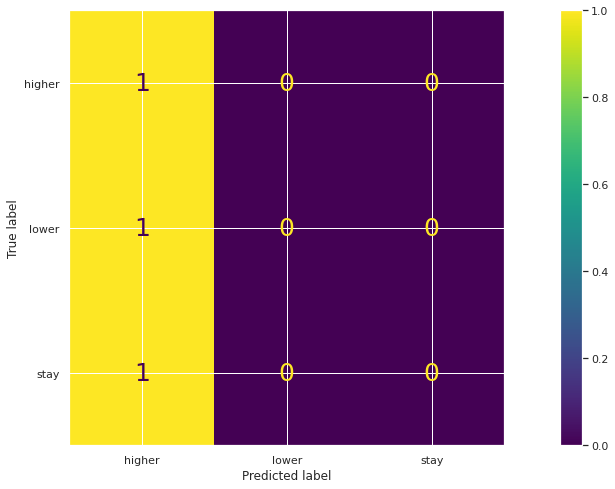

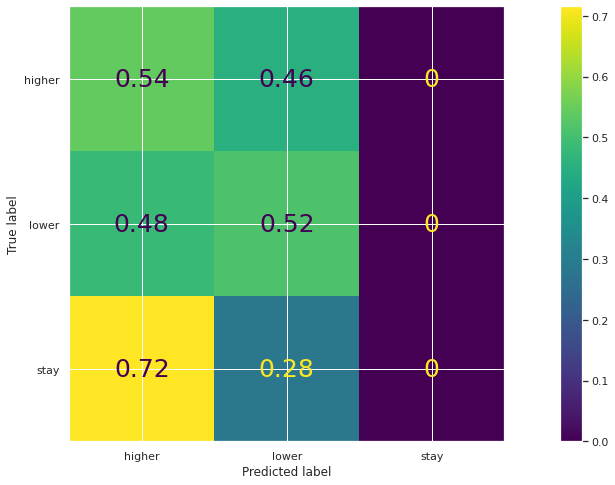

In [24]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix, f1_score

for clf_label, clf in clf_dict.items():
    with mlflow.start_run(run_name=clf_label):
        Y_pred = clf.predict(X_test)
        
        accuracy = accuracy_score(Y_pred, Y_test)
        f1 = f1_score(Y_pred, Y_test, average='weighted')
        


        for param, val in best_params[clf_label].items():
            mlflow.log_param(param, val)
        mlflow.log_metric('acc', accuracy)
        mlflow.log_metric('f1', f1)
        mlflow.sklearn.log_model(clf, "sklearn model")
    
    print(f"[{clf_label}] Accuracy : {accuracy:.2f}, F1 : {f1:.2f}")
    plot_confusion_matrix(clf, X_test, Y_test, normalize='true')

|--- Volume <= 5160650.00
|   |--- PercentageDiff <= 0.37
|   |   |--- RSI(14) <= 65.07
|   |   |   |--- Volume <= 4925800.00
|   |   |   |   |--- PercentageDiff <= 0.11
|   |   |   |   |   |--- PercentageDiff <= -1.36
|   |   |   |   |   |   |--- PercentageDiff <= -1.91
|   |   |   |   |   |   |   |--- Close <= 249.60
|   |   |   |   |   |   |   |   |--- class: higher
|   |   |   |   |   |   |   |--- Close >  249.60
|   |   |   |   |   |   |   |   |--- Close <= 340.80
|   |   |   |   |   |   |   |   |   |--- class: lower
|   |   |   |   |   |   |   |   |--- Close >  340.80
|   |   |   |   |   |   |   |   |   |--- class: higher
|   |   |   |   |   |   |--- PercentageDiff >  -1.91
|   |   |   |   |   |   |   |--- Volume <= 3989000.00
|   |   |   |   |   |   |   |   |--- Volume <= 2992150.00
|   |   |   |   |   |   |   |   |   |--- class: higher
|   |   |   |   |   |   |   |   |--- Volume >  2992150.00
|   |   |   |   |   |   |   |   |   |--- class: higher
|   |   |   |   |   |   |   |--

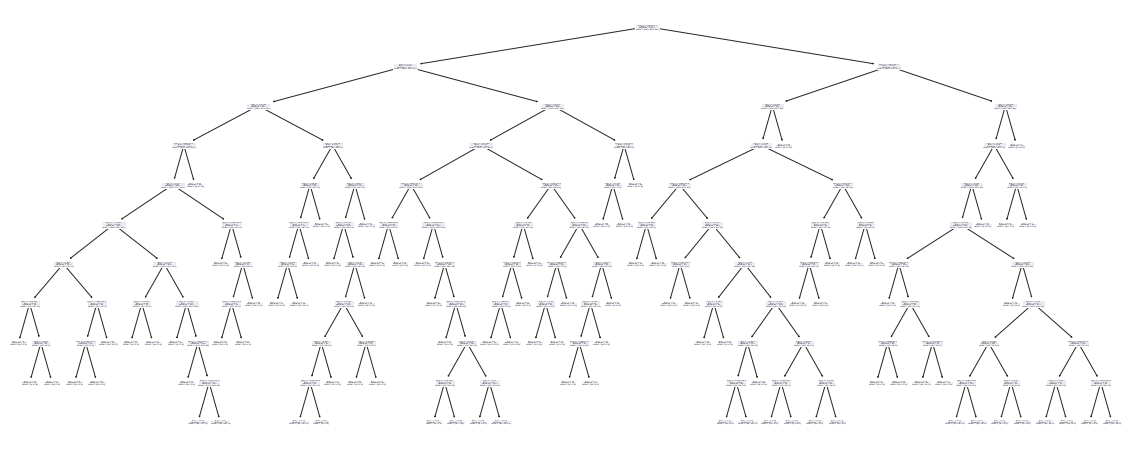

In [25]:
from sklearn import tree
from sklearn.tree import export_text
dtree = clf_dict['DTree']

#print(dtree.feature_importances_)
tree.plot_tree(dtree)

#print(dtree.tree_.feature)



rules = export_text(dtree, feature_names=(list(X_train.columns)))

print(rules)